In [242]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor, nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
torch.manual_seed(0)

# labels for multi-class classification task
CIRCLE = 0
EQ_TRIANGLE = 1
SQUARE = 2
ELLIPSE = 3
RECTANGLE = 4
NON_EQ_TRIANGLE = 5

In [210]:
def shape_label(shape_type):
    """
    """    
    if shape_type == 'circle':
        shape_type = CIRCLE
    elif shape_type == 'ellipse':
        shape_type = ELLIPSE
    elif shape_type == 'square':
        shape_type = SQUARE
    elif shape_type == 'rectangle':
        shape_type = RECTANGLE
    elif shape_type == 'eq_triangle':
        shape_type = EQ_TRIANGLE
    else:
        shape_type = NON_EQ_TRIANGLE
    
    return shape_type

def generate_eq_triangle(image_size):

    triangle_height = np.random.randint(image_size // 4, image_size // 2)
    x1 = np.random.randint(0, image_size - triangle_height)
    y1 = np.random.randint(0, image_size - triangle_height)
    x2 = x1 + triangle_height
    y2 = y1
    x3 = x1 + (triangle_height // 2)
    y3 = y1 + triangle_height
    pts = np.array([[x1, y1], [x2, y2], [x3, y3]], np.int32)
    return pts
    

def generate_non_eq_triangle(image_size):
    side_a = np.random.randint(image_size // 4, image_size // 2)
    side_b = np.random.randint(image_size // 4, image_size // 2)
    side_c = np.random.randint(image_size // 4, image_size // 2)

    while not (side_a + side_b > side_c and side_b + side_c > side_a and side_a + side_c > side_b):
        side_a = np.random.randint(image_size // 4, image_size // 2)
        side_b = np.random.randint(image_size // 4, image_size // 2)
        side_c = np.random.randint(image_size // 4, image_size // 2)

    while side_a == side_b or side_b == side_c or side_a == side_c:
        side_a = np.random.randint(image_size // 4, image_size // 2)
        side_b = np.random.randint(image_size // 4, image_size // 2)
        side_c = np.random.randint(image_size // 4, image_size // 2)

    x1 = np.random.randint(0, image_size - side_a - 1)
    y1 = np.random.randint(0, image_size - side_b - 1)
    x2 = x1 + side_a
    y2 = y1
    x3 = np.random.randint(x1 + side_b, x1 + side_a + side_c)
    y3 = y1 + side_b

    pts = np.array([[x1, y1], [x2, y2], [x3, y3]], np.int32)

    return pts


def generate_shape(image_size, complex=False):

    # add more complicated shapes for complex dataset
    shape_type = np.random.choice(
        ['rectangle', 'ellipse', 'non_eq_triangle']) if complex else np.random.choice(['square', 'circle', 'eq_triangle'])
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    if shape_type == 'square':
        side_length = np.random.randint(image_size // 4, image_size // 2)
        x = np.random.randint(0, image_size - side_length)
        y = np.random.randint(0, image_size - side_length)
        image[y:y+side_length, x:x+side_length] = 255

    elif shape_type == 'circle':
        radius = np.random.randint(image_size // 8, image_size // 4)
        center_x = np.random.randint(radius, image_size - radius)
        center_y = np.random.randint(radius, image_size - radius)
        cv2.circle(image, (center_x, center_y), radius, 255, -1)

    elif shape_type == 'rectangle':
        width = np.random.randint(image_size // 4, image_size // 2)
        height = np.random.randint(image_size // 4, image_size // 2)
        x = np.random.randint(0, image_size - width)
        y = np.random.randint(0, image_size - height)
        image[y:y+height, x:x+width] = 255

    elif shape_type == 'ellipse':
        major_axis = np.random.randint(image_size // 4, image_size // 2)
        minor_axis = np.random.randint(image_size // 4, image_size // 2)
        center_x = np.random.randint(major_axis, image_size - major_axis)
        center_y = np.random.randint(minor_axis, image_size - minor_axis)
        cv2.ellipse(image, (center_x, center_y),
                    (major_axis, minor_axis), 0, 0, 360, 255, -1)

    elif shape_type == 'eq_triangle':
        pts = generate_eq_triangle(image_size)
        cv2.fillPoly(image, [pts], 255)

    elif shape_type == 'non_eq_triangle':
        pts = generate_non_eq_triangle(image_size)
        cv2.fillPoly(image, [pts], 255)

    return image.astype(np.float32), shape_type

In [246]:
def generate_shape_dataset(num_examples, image_size, complex=False):

    dataset, labels = [], []
    for _ in range(num_examples):
        shape_image, shape_type = generate_shape(image_size, complex=complex)
        shape_type = shape_label(shape_type)
        dataset.append(shape_image)
        labels.append(shape_type)

    return tensor(dataset, dtype=torch.float32), tensor(labels, dtype=torch.long)

dataset_size = 5000
image_size = 64

dataset_basic, labels_basic = generate_shape_dataset(
    num_examples=dataset_size, image_size=image_size, complex=False)
dataset_complex, labels_complex = generate_shape_dataset(
    num_examples=dataset_size, image_size=image_size, complex=True)

dataset_combined = torch.cat((dataset_basic, dataset_complex), dim=0)
labels_combined = torch.cat((labels_basic, labels_complex), dim=0)

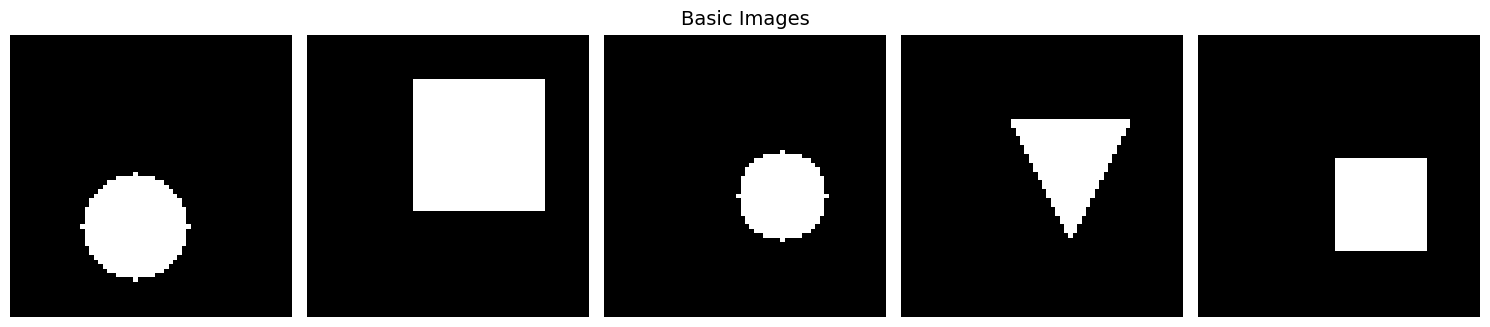

In [248]:
# visualize a few examples
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):

    axes[i].imshow(dataset_basic[i], cmap='gray')
    axes[i].axis('off')

plt.suptitle('Basic Images', y=0.75, fontsize=14)

plt.tight_layout()
plt.show()

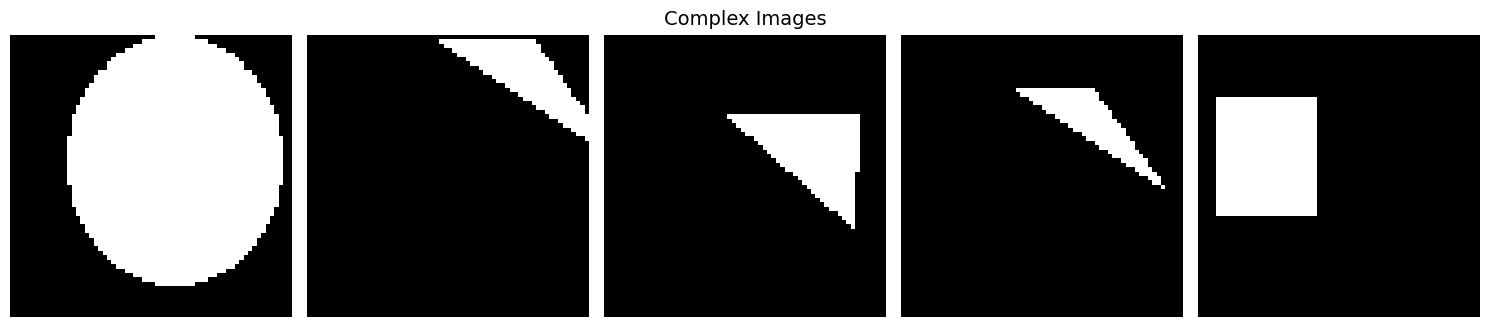

In [249]:
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):

    axes[i].imshow(dataset_complex[i], cmap='gray')
    axes[i].axis('off')

# Add label for the top row
plt.suptitle('Complex Images', y=0.75, fontsize=14)

plt.tight_layout()
plt.show()

In [260]:
class ShapeDataset(Dataset):
    def __init__(self, dataset, labels, num_classes):
        self.data = dataset
        self.labels = labels
        self.num_classes = num_classes
        self.num_samples = dataset.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


def prepare_data(dataset, labels, batch_size, num_classes, shuffle=False):

    X_train, X_test, y_train, y_test = train_test_split(dataset, labels,
                                                        train_size=0.8, test_size=0.2)

    train_dataset = ShapeDataset(
        dataset=X_train, labels=y_train, num_classes=num_classes)
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)

    test_dataset = ShapeDataset(
        dataset=X_test, labels=y_test, num_classes=num_classes)
    test_loader = DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, test_loader

num_classes = 6
batch_size = 32

train_loader_basic, test_loader_basic = prepare_data(
    dataset=dataset_basic, labels=labels_basic, batch_size=batch_size, num_classes=num_classes, shuffle=False)

train_loader_complex, test_loader_complex = prepare_data(
    dataset=dataset_complex, labels=labels_complex, batch_size=batch_size, num_classes=num_classes, shuffle=False)

train_loader_combined, test_loader_combined = prepare_data(
    dataset=dataset_combined, labels=labels_combined, batch_size=batch_size, num_classes=num_classes, shuffle=True)

In [261]:
from torch.nn.functional import tanh, softmax

class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = tanh(self.layer1(x))
        x = tanh(self.layer2(x))
        x = softmax(self.layer3(x), dim=-1, dtype=torch.float32)
        return x

def train_model(model, loader, loss_fn, optimizer, num_epochs=100, verbose=False):
    best_acc = float('-inf')
    for epoch in range(num_epochs):
        total, num_correct = 0, 0
        for images, labels in tqdm(loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
            
            images = images.view(images.size(0), -1)  # flatten images
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # make prediction by choosing most likely outcome
            predictions = torch.argmax(outputs, dim=-1)

            # keep tabs on accuracy score
            num_correct += (predictions == labels).sum().item()
            total += labels.shape[0]

        acc = num_correct / total
        if verbose:
            print(f'Epoch {epoch + 1}, Accuracy: {acc}')
        
        best_acc = acc if acc > best_acc else best_acc

    print(f"Model accuracy after training: {best_acc}")
    return model

In [262]:
input_size = image_size * image_size
hidden_size = 256
output_size = 6

model_basic = FeedForward(input_size=input_size,
                          hidden_size=hidden_size, output_size=output_size)

model_curriculum = FeedForward(input_size=input_size,
                          hidden_size=hidden_size, output_size=output_size)

model_complex = FeedForward(input_size=input_size,
                            hidden_size=hidden_size, output_size=output_size)

model_combined = FeedForward(input_size=input_size,
                             hidden_size=hidden_size, output_size=output_size)

ce_loss = nn.CrossEntropyLoss()
optimizer_basic = optim.Adam(model_basic.parameters(), lr=0.001)
optimizer_curriculum = optim.Adam(model_curriculum.parameters(), lr=0.001)
optimizer_complex = optim.Adam(model_complex.parameters(), lr=0.001)
optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.001)

num_epochs = 100

In [263]:
print("Training basic model on basic data...")
model_basic = train_model(model=model_basic, loader=train_loader_basic,
                          loss_fn=ce_loss, optimizer=optimizer_basic, num_epochs=num_epochs, verbose=False)
print("Basic data training complete for basic model!")

Training basic model on basic data...


Model accuracy after training: 0.717
Basic data training complete for basic model!


In [264]:
# train the curriculum model on the basic dataset first, then the complex one
print("Training curriculum model on basic data...")

model_curriculum = train_model(model=model_curriculum, loader=train_loader_basic,
                               loss_fn=ce_loss, optimizer=optimizer_curriculum, num_epochs=num_epochs, verbose=False)

print("Basic data training complete for curriculum model!")

Training curriculum model on basic data...


Model accuracy after training: 0.711
Basic data training complete for curriculum model!


In [265]:

print("Training curriculum model on complex data...")
optimizer_curriculum = optim.Adam(model_curriculum.parameters(), lr=0.001) # update optimizer based on first training
model_curriculum = train_model(model=model_curriculum, loader=train_loader_complex,
                               loss_fn=ce_loss, optimizer=optimizer_curriculum, num_epochs=num_epochs, verbose=False)

print("Complex data training complete for curriculum model!")

Training curriculum model on complex data...


Model accuracy after training: 0.9865
Complex data training complete for curriculum model!


In [266]:
print("Training complex model on complex data...")

model_complex = train_model(model=model_complex, loader=train_loader_complex,
                         loss_fn=ce_loss, optimizer=optimizer_complex, num_epochs=num_epochs, verbose=False)

print("Complex data training complete for complex model!")

Training complex model on complex data...


Model accuracy after training: 0.97225
Complex data training complete for complex model!


In [267]:
print("Training combined model on all data...")

model_combined = train_model(model=model_combined, loader=train_loader_combined,
                             loss_fn=ce_loss, optimizer=optimizer_combined, num_epochs=num_epochs, verbose=False)

print("Combined data training complete on combined model!")

Training combined model on all data...


Model accuracy after training: 0.649
Combined data training complete on combined model!


In [269]:
def test_model(model, loader, model_type='basic'):

    total, num_correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(images.size(0), -1)  # flatten images
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=-1)
            num_correct += (predictions == labels).sum().item()
            total += labels.shape[0]
    acc = num_correct/total
    print(f"{model_type} test accuracy: {num_correct/total}")
    return acc

# base model performance on combined data
basic_test_acc = test_model(model=model_basic, loader=test_loader_combined, model_type='basic')
curriculum_test_acc = test_model(model=model_curriculum, loader=test_loader_combined, model_type='curriculum')
complex_test_acc = test_model(model=model_complex, loader=test_loader_combined, model_type='complex')
combined_test_acc = test_model(model=model_combined, loader=test_loader_combined, model_type='combined')

basic test accuracy: 0.341
curriculum test accuracy: 0.478
complex test accuracy: 0.4725
combined test accuracy: 0.5645
